# Model Validation

In [3]:
import glob
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from main import data_transforms
from collections import defaultdict
from sklearn.metrics import classification_report

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the saved model

In [4]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)
model.load_state_dict(torch.load('ct_model_adam_001lr.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

## Load some example images using PIL

In [5]:
PIL_images = []
filenames = []

labels = ["2_2", "3_4", "4_4"]
rand_labels = [labels[n] for n in np.random.randint(0, 3, 20)]

imagePaths = {
    "2_2": glob.glob("data/val/2_2/*.png"),
    "3_4": glob.glob("data/val/3_4/*.png"),
    "4_4": glob.glob("data/val/4_4/*.png")
}

for i in range(len(rand_labels)):
    label = rand_labels[i]
    imagePathSet = imagePaths[label]

    setInd = int(np.random.random() * len(imagePathSet))

    im = Image.open(imagePathSet[setInd])
    PIL_images.append(im)
    # image_labels.append(label)
    filenames.append(imagePathSet[setInd])

In [6]:
class_count = [len(imagePaths[lbl]) for lbl in labels]
class_count

[357, 200, 130]

### Use the validation image transformer.

In [7]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
    image = image.clip(0, 1)
    return image

tensor_images = []
for im in PIL_images:
    im = data_transforms['val'](im)
    tensor_images.append(im)
    im = im_convert(im)

## Use model to make predictions

In [8]:
predictions = []
for im in tensor_images:
    image = im.to(device).unsqueeze(0)
    output = model(image)
    _, pred = torch.max(output, 1)
    predictions.append(pred.item())

In [9]:
predictions

[2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 1, 2]

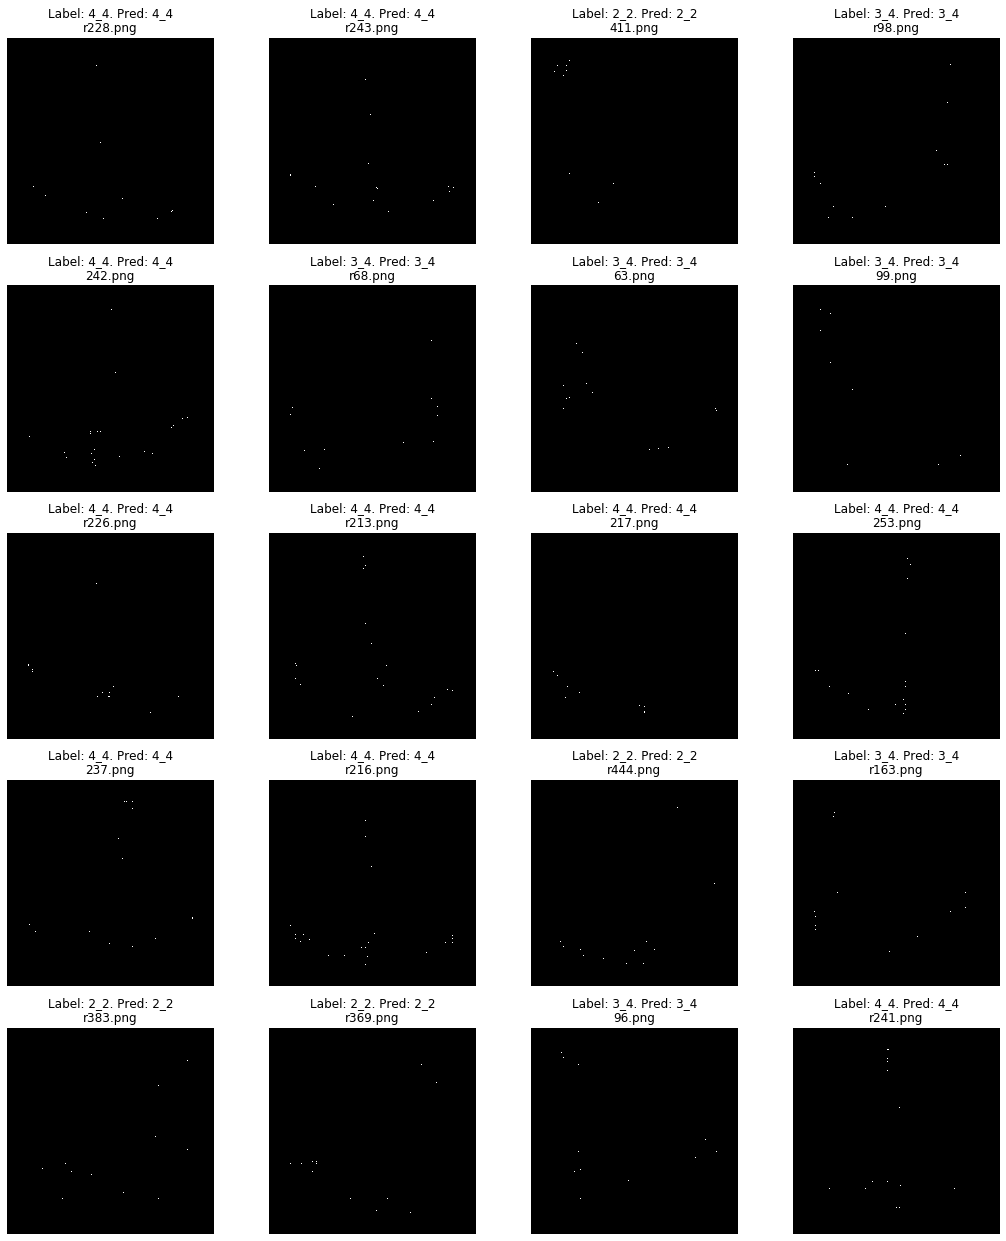

In [10]:
plt.figure(figsize=(18, 22))
for i in range(len(PIL_images)):
    plt.subplot(5, 4, i+1)
    plt.imshow(PIL_images[i])
    plt.axis("off")
    plt.title("Label: " + rand_labels[i] + ". Pred: " + str(labels[predictions[i]]) + "\n" + filenames[i].split('_')[-1])

In [11]:
confusion_acc = defaultdict(int)

In [12]:
# labels = ["2_2", "3_4", "4_4"]
img_labels = []
predictions = []

for label in labels:
    totalImages = len(imagePaths[label])
    tensor_ims = []
    for imagePath in imagePaths[label]:
        img_labels.append(label)
        im = Image.open(imagePath)
        tensor_ims.append(data_transforms['val'](im))
    
    
    for im in tensor_ims:
        image = im.to(device).unsqueeze(0)
        output = model(image)
        _, pred = torch.max(output, 1)
        predInd = pred.item()
        predictions.append(predInd)
        confusion_acc[(label, labels[predInd])] += 1

In [13]:
confusion_acc

defaultdict(int,
            {('2_2', '2_2'): 355,
             ('2_2', '3_4'): 2,
             ('3_4', '3_4'): 200,
             ('4_4', '4_4'): 130})

In [14]:
import pandas as pd
confusion_matrix = pd.DataFrame()
for expected in labels:
    for predicted in labels:
        confusion_matrix.loc[expected, predicted] = confusion_acc[(expected, predicted)]

for i in confusion_matrix.index:
    confusion_matrix.loc[i, "acc"] = confusion_matrix.loc[i, i] / np.sum(confusion_matrix.loc[i, :])

In [15]:
confusion_matrix

,2_2,3_4,4_4,acc
2_2,355.0,2.0,0.0,0.994398
3_4,0.0,200.0,0.0,1.000000
4_4,0.0,0.0,130.0,1.000000


In [16]:
pred_labels = [labels[p] for p in predictions]
print(classification_report(img_labels, pred_labels))

              precision    recall  f1-score   support

         2_2       1.00      0.99      1.00       357
         3_4       0.99      1.00      1.00       200
         4_4       1.00      1.00      1.00       130

    accuracy                           1.00       687
   macro avg       1.00      1.00      1.00       687
weighted avg       1.00      1.00      1.00       687

